In [1]:
#load libraries
#load libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import math
import os
#import matplotlib
#matplotlib.use('Qt4Agg')
#from matplotlib import pyplot as plt
%matplotlib qt
print('done')

done


In [2]:
#Camera Calibration and Undistortion of Test Images
"load images and return camera calibration matrix and distance of corners from the perspective point in the image"
def do_camera_calibration(source):

    # define arrays to get object and image points collections.
    objpoints = [] #3D points in real world image
    imgpoints = [] #2D points in image plane
    #load images from source
    filenames=os.listdir(source)
    for fname in filenames:
        img=cv2.imread(source+fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #prepare object points in 3D from (0,0,0),....,(8,5,0)
        objp=np.zeros((6*9,3),np.float32)
        objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)
        #find corners in the chessboard square
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret==True:
            objpoints.append(objp)
            imgpoints.append(corners)
        else:
            print('Cannot process image...',fname)
   
    #calibration code
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,img.shape[0:2],None, None)
    return mtx,dist


print('done')

done


In [3]:
#test for chessboard images
source = 'camera_cal/'
mtx, dist = do_camera_calibration(source)
print('done')

Cannot process image... calibration1.jpg
Cannot process image... calibration4.jpg
Cannot process image... calibration5.jpg
done


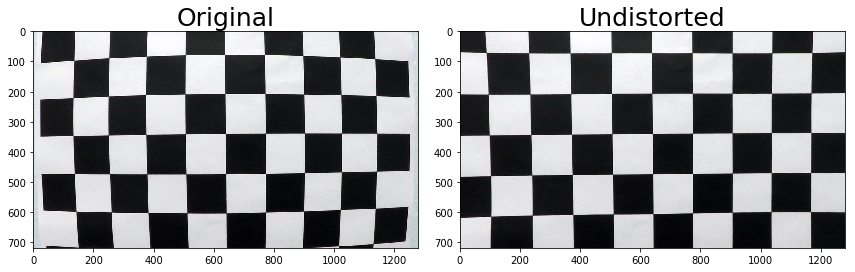

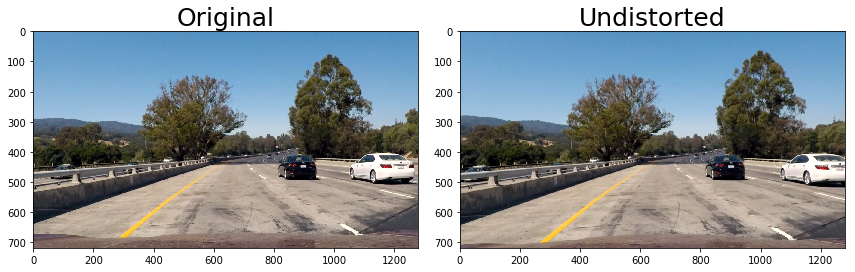

In [4]:
#plotting and display undistorted images
#trying on chessboard images
img = cv2.imread('camera_cal/calibration1.jpg')
ret, corners = cv2.findChessboardCorners(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),(9,6), None)
img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
undist = cv2.undistort(img,mtx,dist,None,mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=25)
ax2.imshow(undist)
ax2.set_title('Undistorted', fontsize=25)
#trying on a test image
img = mpimg.imread('test_images/test1.jpg')#used mpimg to read RGB format and again avoiding BGR image space conversion
undist = cv2.undistort(img,mtx,dist,None,mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=25)
ax2.imshow(undist)
ax2.set_title('Undistorted', fontsize=25)

In [5]:
#Processing for thresholds and binary images
def color_transform(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary
print('done')

done


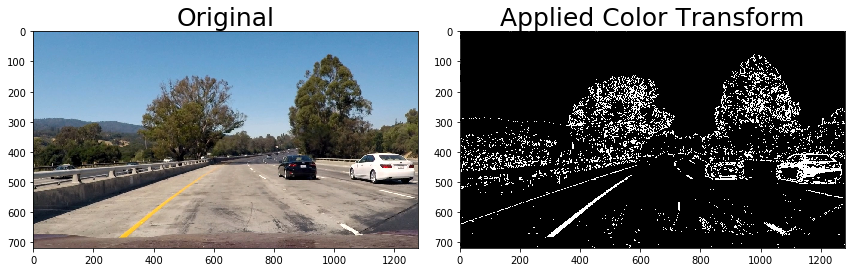

In [6]:
# Plotting thresholded images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
fig.tight_layout()
ax1.set_title('Original',fontsize=25)
ax1.imshow(img)
combined_binary = color_transform(img)
ax2.set_title('Applied Color Transform',fontsize=25)
ax2.imshow(combined_binary, cmap='gray')



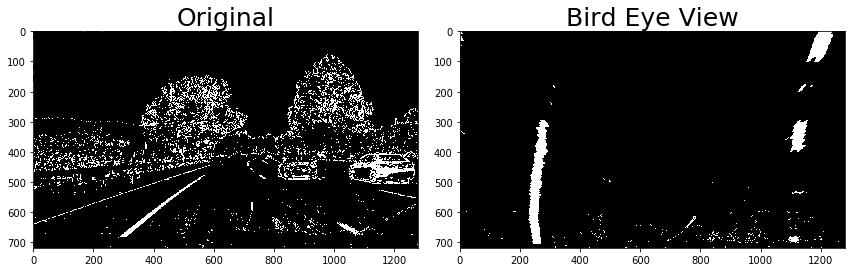

In [7]:
#perspective transform
def perspective_transform(combined_binary):
    img_size = (combined_binary.shape[1], combined_binary.shape[0])
    src = np.float32([[585,455],[705,455],[1130,720],[190,720]])
    dst = np.float32([[200,0],[1080, 0],[1080,  720],[200,720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    binary_warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)  
    return binary_warped, M, Minv
    
binary_warped, M, Minv = perspective_transform(combined_binary)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
fig.tight_layout()
ax1.set_title('Original',fontsize=25)
ax1.imshow(combined_binary, cmap='gray')
ax2.set_title('Bird Eye View',fontsize=25)
ax2.imshow(binary_warped, cmap='gray')


leftlane= 257 rightlane= 1118


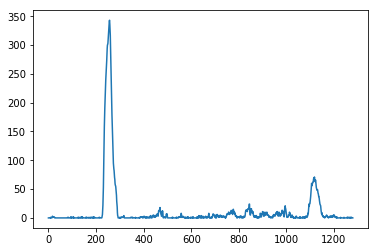

In [8]:
#visualize the histogram for zone of lane-lines
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
half_width = np.int(histogram.shape[0]/2)
leftx = np.argmax(histogram[:half_width])
rightx = np.argmax(histogram[half_width:]) + half_width

print( "leftlane=",leftx,"rightlane=",rightx)
plt.plot(histogram)

(720, 0)

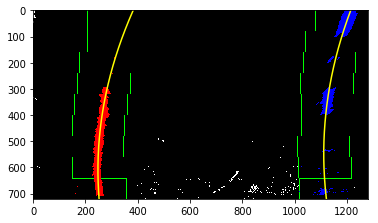

In [9]:
#experimenting the window search
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 



# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

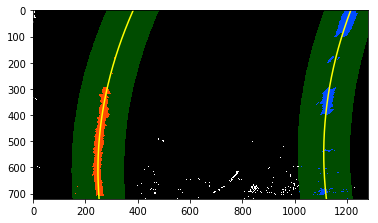

In [10]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [11]:
#Applying on a video stream
cap=cv2.VideoCapture('project_video.mp4')
i=1
#Checking with the video
vidcap = cv2.VideoCapture('project_video.mp4')
success,image = vidcap.read() #Reading the Video file
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('outputvideo.mp4',fourcc,30.0,(1280,720))
while success:
    ret,frame=cap.read()
    img=frame
    undist =cv2.undistort(img,mtx,dist,None,mtx)
    combined_binary= color_transform(undist)
    binary_warped, M, Minv = perspective_transform(combined_binary)
    #Finding the lane lines in the first frame
    if i==1:
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        half_width = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:half_width])
        rightx_base = np.argmax(histogram[half_width:]) + half_width
        nwindows = 9
        window_height = np.int(binary_warped.shape[0]/nwindows)
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        leftx_current = leftx_base
        rightx_current = rightx_base
        margin = 100
        minpix = 50
        left_lane_inds = []
        right_lane_inds = []
        img_size=(img.shape[1],img.shape[0])
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    #Using the found parameters in first frame to find the lines on the coming frames
    i=i+1
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Extracting left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generating x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img = np.dstack((binary_warped,binary_warped,binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    #Finding the deviation of the car from the center of the lane - Lane width is taken as reference
    #to calculate the pixel to real time distance relationship
    
    
   
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    line_pts1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    line_pts2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                                  ploty])))])
    line_pts = np.hstack((line_pts1, line_pts2))
    
    # Draw the lane onto the warped blank image 
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img,np.int_([line_pts]),(0,0,255))
    result = cv2.addWeighted(out_img, 1, window_img, 1.5, 0)
    lefto=cv2.warpPerspective(result,Minv,img_size,flags=cv2.INTER_LINEAR)
    final = cv2.addWeighted(undist, 1, lefto, 0.3, 0)
    
    #finding the curvature of the road and center offset
    #Length of the lane in meters --> 30 -->It is found that 720 pixels are used to represent the lane length
    #Hence meters/pixel in y-direction is 30/720
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    
    left_curverad  = ((1 + (2*left_fit[0]*y_eval*30/720 + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*30/720 + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    curve_rad=np.mean([left_curverad,right_curverad]) #Calculation of radius of curvature
    camera_mid=np.mean((left_fit[0]*y_eval**2+left_fit[1]*y_eval+left_fit[2],right_fit[0]*y_eval**2+right_fit[1]*y_eval+right_fit[2]))
    camera_dist=(camera_mid-640)*xm_per_pix
    #Average_radii=float((left_curverad+right_curverad)/2)
    Average_radii=str.format("{0:.1f}", camera_mid) 
    Center_offset=str.format("{0:.3f}", camera_dist)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text=cv2.putText(final,'Average Radii: '+str(Average_radii)+'M',(10,100), font, 1,(255,0,0),2,cv2.LINE_AA)
    text=cv2.putText(final,'Center_Offset: '+str(Center_offset)+'M',(10,150), font, 1,(255,0,0),2,cv2.LINE_AA)    
    cv2.imshow('Res',text)
    video.write(text)
    success,image = vidcap.read()

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

vidcap.release()
video.release()
cv2.destroyAllWindows()